# Setup

## Setup MNIST dataset and pytorch

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def load_mnist(batch_size):
  trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
  testset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)
  iter_from = lambda dataset: torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
  return iter_from(trainset), iter_from(testset), trainset, testset

mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

train_iter, test_iter, train_set, test_set = load_mnist(batch_size=4)
print(f'Length of training dataset:\t{len(train_set)}')
print(f'Length of test dataset:\t\t{len(test_set)}')

Length of training dataset:	60000
Length of test dataset:		10000


# Neural Network

## Setup Neural Network Parameters

In [ ]:
def create_params():
  n_inputs = 28 * 28
  n_hiddens = 256
  n_outputs = 10

  W1 = 0.01 * torch.randn(size=(n_inputs, n_hiddens))
  W2 = 0.01 * torch.randn(size=(n_hiddens,n_outputs))

  b1 = torch.zeros(size=(1, n_hiddens))
  b2 = torch.zeros(size=(1, n_outputs))

  return [
      torch.nn.Parameter(W1),
      torch.nn.Parameter(b1),
      torch.nn.Parameter(W2),
      torch.nn.Parameter(b2)
  ]

params = create_params()

## Network Definition

In [ ]:
def relu(x):
  return torch.clamp(x, min=0)

def softmax(X):
  # Lower the bias of the terms to improve numerical stability
  # This doesn't affect the output since softmax is invariant under addition of bias terms
  X_exp = torch.exp(X - torch.max(X, dim=1, keepdim=True)[0])
  return X_exp / torch.sum(X_exp, dim=1, keepdim=True)

def net(X):
  # Turn 28x28 input images into 786x1 tensor
  X = X.view(X.shape[0], -1)

  H = relu(X @ params[0] + params[1])
  O = softmax(H @ params[2] + params[3])

  return O

## Test the forward pass

In [ ]:
from T3_P3_TestCases import test_forward_pass

params = create_params()
test_forward_pass(net)

Forward pass test passed!


# Training

## Cross-entropy loss and gradient descent

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(y.size(0)), y])

def sgd(params, lr=0.1):
  for param in params:
      param.data -= lr * param.grad
      param.grad.zero_()

## Simple training Loop

In [ ]:
def train(net, params, train_iter, loss_func=cross_entropy, updater=sgd):
  for X, y in train_iter:
      loss = torch.mean(loss_func(net(X), y))
      loss.backward()
      updater(params)

In [ ]:
epochs = 10
batch_size = 128
lr = 0.1
train_iter, test_iter, _, _ = load_mnist(batch_size=batch_size)
params = create_params()
train(net, params, train_iter)

## Training loop with metrics

In [ ]:
def accuracy(y_hat, y):
  with torch.no_grad():
    y_labels = y_hat.argmax(axis=1)
    correct = y_labels == y
    return correct.sum() / correct.numel()


def train(net, params, train_iter, test_iter, loss, updater):
  train_losses, train_accs = [], []
  test_losses, test_accs = [], []

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = 0.0, 0.0
    trials = 0

    for X, y in train_iter:
      trials += 1
      y_hat = net(X)
      l = loss(y_hat, y).mean()
      acc = accuracy(y_hat, y)

      l.backward()
      updater(params, lr)

      train_loss += l
      train_acc += acc

    train_losses.append(train_loss.item() / trials)
    train_accs.append(train_acc.item() / trials)

    test_loss, test_acc = 0.0, 0.0
    trials = 0

    y_pred = []
    y_true = []

    for X, y in test_iter:
      trials += 1
      with torch.no_grad():
        y_hat = net(X)

        # Recording for confusion matrix
        if epoch == epochs-1:
          y_pred += y_hat.argmax(axis=1)
          y_true += y

        l = loss(y_hat, y).mean()
        acc = accuracy(y_hat, y)

        test_loss += l
        test_acc += acc

    test_losses.append(test_loss.item() / trials)
    test_accs.append(test_acc.item() / trials)

  return train_losses, train_accs, test_losses, test_accs, y_pred, y_true

In [ ]:
epochs = 10
batch_size = 128
lr = 0.1
train_iter, test_iter, _, _ = load_mnist(batch_size=batch_size)
params = create_params()
train_losses, train_accs, test_losses, test_accs, y_pred, y_true = train(net, params, train_iter, test_iter, loss=cross_entropy, updater=sgd)

100%|██████████| 10/10 [02:07<00:00, 12.72s/it]


# Analysis

## Graph the loss and confusion matrix over time

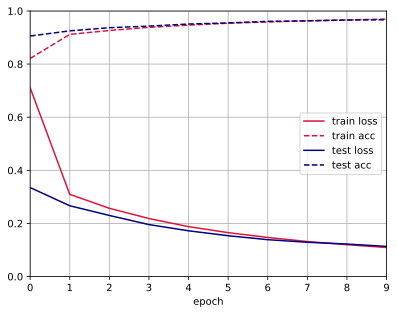

In [ ]:
plt.plot(train_losses, c='crimson', label='train loss')
plt.plot(train_accs, '--', c='crimson', label='train acc')
plt.plot(test_losses, c='navy', label='test loss')
plt.plot(test_accs, '--', c='navy', label='test acc')

plt.xlabel('epoch')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, epochs-1)
plt.legend()
plt.savefig('final_plot.pdf')
plt.show()

## Confusion matrix

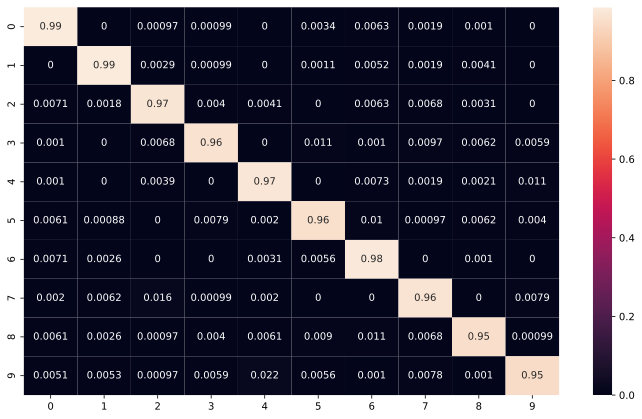

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in mnist_labels],
                     columns = [i for i in mnist_labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')

## Out of Distribution Analysis

### Setup the dataset

In [ ]:
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [ ]:
# Constructing our train data to be full of just 1's and 6's
new_train_set = []
for X, y in trainset:
    if y == 1 or y == 6:
        new_train_set.append((X, y))

# Constructing our in-distribution test data to be full of just 1's and 6's
in_test_set = []
for X, y in testset:
    if y == 1 or y == 6:
        in_test_set.append((X, y))

# Constructing our out-of-distribution test data to be full of just 3's
out_test_set = []
for X, y in testset:
    if y == 3:
        out_test_set.append((X, y))

iter_from = lambda dataset: torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

train_iter = iter_from(new_train_set)
in_test_iter = iter_from(in_test_set)
out_test_iter = iter_from(out_test_set)

### Rerun loop



In [ ]:
def new_train_test_function(net, params, train_iter, in_test, out_test, loss, updater):
  for _ in tqdm(range(epochs)):
    trials = 0

    for X, y in train_iter:
      trials += 1
      y_hat = net(X)
      l = loss(y_hat, y).mean()

      l.backward()
      updater(params, lr)

  # In distribution
  test_acc = 0.0
  trials = 0
  for X, y in in_test:
    trials += 1
    with torch.no_grad():
      y_hat = net(X)
      l = loss(y_hat, y).mean()
      acc = accuracy(y_hat, y)
      test_acc += acc

  print("Test Accuracy (In Distribution): " + str(test_acc.item() / trials))

  # Out of distribution
  test_acc = 0.0
  trials = 0
  for X, y in out_test:
    trials += 1
    with torch.no_grad():
      y_hat = net(X)
      l = loss(y_hat, y).mean()
      acc = accuracy(y_hat, y)

      test_acc += acc

  print("Test Accuracy (Out of Distribution): " + str(test_acc.item() / trials))

In [ ]:
params = create_params()
new_train_test_function(net, params, train_iter, in_test_iter, out_test_iter, loss=cross_entropy, updater=sgd)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Test Accuracy (In Distribution): 0.9963235294117647
Test Accuracy (Out of Distribution): 0.0
